In [1]:

import pandas as pd
import torch 
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.nn import BCEWithLogitsLoss, Linear, Module, ReLU, Sequential, Softmax
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from torch.optim import Adam

import numpy as np
from imblearn.over_sampling import RandomOverSampler

import seaborn as sns
import matplotlib.pyplot as plt
import transformers


import tensorflow as tf
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import SparseCategoricalAccuracy
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer




2023-12-09 21:00:30.725622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 21:00:32.334110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


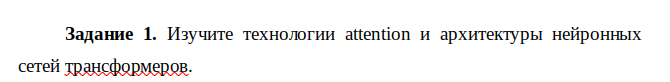

С английского языка Attention переводится как «внимание». Этот термин правильно описывает суть подхода: если вы автомобилист и на фотографии изображён генерал ГИБДД, вы интуитивно придаёте ему важность, вне зависимости от контекста фотографии. Вы скорее всего пристальнее взглянете на генерала. Вы напряжёте глаза, рассмотрите погоны внимательнее: сколько у него там конкретно звёзд. Если генерал не очень высокий, проигнорируете его. В противном случае учтёте как ключевой фактор при принятии решений. Так работает наш мозг. В Русской культуре мы натренированы поколениями на внимание к высоким чинам, наш мозг автоматически ставит высокий приоритет таким объектам.

Attention представляет собой способ сообщить сети, на что стоит обратить больше внимания, то есть сообщить вероятность того или иного исхода в зависимости от состояния нейронов и поступающих на вход данных. 

Сам по себе механизм формирует матрицу весов важности. Если бы мы не обучали Attention, мы могли бы задать важность, например, эмпирически (генерал важнее прапорщика). Но когда мы обучаем сеть на данных, важность становится функцией вероятности того или иного исхода в зависимости от поступивших на вход сети данных. 

Трансформер (англ. transformer) — архитектура глубоких нейронных сетей, основанная на механизме внимания без использования рекуррентных нейронных сетей (сокр. RNN). Самое большое преимущество трансформеров по сравнению с RNN заключается в их высокой эффективности в условиях параллелизации.

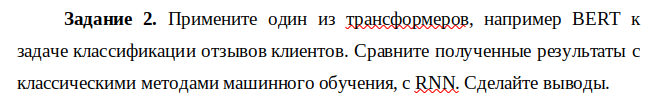

In [43]:
   pip install torch transformers

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [219]:
# считаем данные 
data = pd.read_excel('all_reviews.xlsx', usecols=['review', 'rating'])
data

,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",5
1,Свежий и вкусный кекс с банановый вкусом и оре...,5
2,Вау вау,5
3,"ужасный вкус, не советую к покупке",1
4,Понравился и мне и коллегам,5
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",5
1956,супер,5
1957,отличное спелое манго!,5
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",5


In [220]:
# изменим классы 1->0, 2-> 1 и так далее
labels_dct = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
data = (data
      .query("rating in @labels_dct.keys()")
      .assign(rating=lambda x: x["rating"].replace(labels_dct)))

data


,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",4
1,Свежий и вкусный кекс с банановый вкусом и оре...,4
2,Вау вау,4
3,"ужасный вкус, не советую к покупке",0
4,Понравился и мне и коллегам,4
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",4
1956,супер,4
1957,отличное спелое манго!,4
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",4


In [221]:
# разделим данные на тест и трэин
X = data.review
y = data.rating

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [291]:
# обработаем данные 
# токенизируем текст, преобразуем его во входные идентификаторы, маски внимания и метки.


class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

#  возвращает словарь, который состоит из самого исходного текста, списка токенов, маски внимания, а также метки класса. 
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # В этом методе мы указываем токенизатору, что нужно дополнять полученные векторы до максимально длины padding='max_len'.
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label)
        }


In [292]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')   
# Токенайзер загружаем из репозитория huggingface rubert-tiny.
tokenizer_path = 'cointegrated/rubert-tiny'
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

In [293]:
# bert_model = BertModel.from_pretrained('bert-base-uncased')
# bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')


# Используем русскоязычую модель BERT из репозитория huggingface rubert-tiny. 
model_path = 'cointegrated/rubert-tiny'
model = BertForSequenceClassification.from_pretrained(model_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [294]:
# Для классификации необходимо добавить полносвязный слой, количество входов которого — внутренняя размерность эмбеддинга сети, а выход - число классов для классификации. 

# У нас происходит классификация на 5 классов (рейтинг отзыва 1-5)
# внутренняя размерность эмбедингов
out_features = model.bert.encoder.layer[1].output.dense.out_features
out_features

312

In [295]:
# В нашем случае размерность равна 312. Конфигурируем полносвязный слой
model.classifier = torch.nn.Linear(312, 5)

In [321]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 20
max_len = 512
model_save_path='./content/bert.pt'

In [322]:
class BERTClassifier(Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.classifier = Sequential(
            Linear(768, 256),
            ReLU(),
            Linear(256, num_classes),
            Softmax(dim=1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [323]:
train_set = CustomDataset(X_train, y_train, tokenizer, max_len)
valid_set = CustomDataset(X_test, y_test, tokenizer, max_len)

# create data loaders
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=2, shuffle=True)

# helpers initialization
optimizer = Adam(model.parameters(), lr=2e-5)

# Планировщик, нужен для настройки параметров оптимизатора во время обучения. В качестве входных параметров передаем оптимизатор, а так же общее количество шагов для обучения, которое равно произведению количества батчей тренировочной выборки на количество эпох обучения
scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * epochs
        )
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [324]:
def model_train(model, train_loader, train_set, device, loss_fn, optimizer, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    i = 0

    # Данные в цикле батчами генерируются с помощью DataLoader
    try:
        i += 1
        for data in train_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["label"].to(device)

            # Батч подается в модель
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # На выходе получаем распределение вероятности по классам и значение ошибки
            preds = torch.argmax(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

        # обратное распространение ошибки;
            loss.backward()
            # обрезаем градиенты для предотвращения "взрыва" градиентов;
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            #  шаг оптимизатора
            optimizer.step()
            # шаг планировщика
            scheduler.step()
            # обнуляем градиенты.
            optimizer.zero_grad()
    except Exception:
        print(i)

    train_acc = correct_predictions / len(train_set)
    train_loss = np.mean(losses)
    return train_acc, train_loss

In [325]:
def model_test(model, valid_loader, valid_set, device, loss_fn):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    i = 0

    with torch.no_grad():
        i += 1
        try:
            for data in valid_loader:
                input_ids = data["input_ids"].to(device)
                attention_mask = data["attention_mask"].to(device)
                targets = data["label"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        except Exception:
            print(i)
    
    val_acc = correct_predictions / len(valid_set)
    val_loss = np.mean(losses)
    return val_acc, val_loss

In [326]:
# Для обучения на нескольких эпохах используется метод train, в котором последовательно вызываются методы model_train и model_test.

def train(epochs, model_train, model_test, model, train_loader, train_set, valid_loader, valid_set, device, loss_fn, optimizer, scheduler):
    best_accuracy = 0
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_acc, train_loss = model_train(model, train_loader, train_set, device, loss_fn, optimizer, scheduler)
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = model_test(model, valid_loader, valid_set, device, loss_fn)
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print('-' * 10)

        if val_acc > best_accuracy:
            torch.save(model, model_save_path)
            best_accuracy = val_acc


In [327]:
train(epochs, model_train, model_test, model, train_loader, train_set, valid_loader, valid_set, device, loss_fn, optimizer, scheduler)

Epoch 1/20
1
Train loss 0.812972903251648 accuracy 0.0012755101779475808
1
Val loss nan accuracy 0.0
----------
Epoch 2/20
1
Train loss nan accuracy 0.0
1
Val loss nan accuracy 0.0
----------
Epoch 3/20
1
Train loss nan accuracy 0.0
1
Val loss nan accuracy 0.0
----------
Epoch 4/20
1
Train loss 0.8960660696029663 accuracy 0.0012755101779475808
1
Val loss nan accuracy 0.0
----------
Epoch 5/20
1
Train loss nan accuracy 0.0
1
Val loss nan accuracy 0.0
----------
Epoch 6/20
1
Train loss nan accuracy 0.0
1
Val loss nan accuracy 0.0
----------
Epoch 7/20
1
Train loss 0.7815405130386353 accuracy 0.0012755101779475808
1
Val loss nan accuracy 0.0
----------
Epoch 8/20
1
Train loss 1.0971654256184895 accuracy 0.0025510203558951616
1
Val loss nan accuracy 0.0
----------
Epoch 9/20
1
Train loss 0.7043002247810364 accuracy 0.0012755101779475808
1
Val loss nan accuracy 0.0
----------
Epoch 10/20
1
Train loss nan accuracy 0.0
1
Val loss nan accuracy 0.0
----------
Epoch 11/20
1
Train loss 0.70398542

In [328]:
# model = torch.load(model_save_path)

## 1.2

In [23]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [45]:
# считаем данные 
data = pd.read_excel('all_reviews.xlsx', usecols=['review', 'rating'])
data

,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",5
1,Свежий и вкусный кекс с банановый вкусом и оре...,5
2,Вау вау,5
3,"ужасный вкус, не советую к покупке",1
4,Понравился и мне и коллегам,5
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",5
1956,супер,5
1957,отличное спелое манго!,5
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",5


In [46]:
# изменим классы 1->0, 2-> 1 и так далее
labels_dct = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
data = (data
      .query("rating in @labels_dct.keys()")
      .assign(rating=lambda x: x["rating"].replace(labels_dct)))

data

,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",4
1,Свежий и вкусный кекс с банановый вкусом и оре...,4
2,Вау вау,4
3,"ужасный вкус, не советую к покупке",0
4,Понравился и мне и коллегам,4
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",4
1956,супер,4
1957,отличное спелое манго!,4
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",4


In [47]:
# разделим данные на тест и трэин
X = data.review
y = data.rating

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [50]:
# токенизируем и закодируем тексты
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

In [51]:
# Создадим датасеты
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_numpy()
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.to_numpy()
)).batch(16)

In [52]:
# загрузим предобученную модель
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [53]:
# заморозим слои модели
bert_model.trainable = False

In [54]:
num_classes = 5

# Build the classification model
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)[0]
outputs = tf.keras.layers.GlobalMaxPooling1D()(outputs)

dense = tf.keras.layers.Dense(128, activation='relu')(outputs)
dropout = tf.keras.layers.Dropout(0.1)(dense)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

In [55]:
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output])

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
model.fit(train_dataset, epochs=5)

Epoch 1/5


/home/lizik/.local/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


98/98 [==============================] - 562s 6s/step - loss: 0.9375 - accuracy: 0.7398
Epoch 2/5
98/98 [==============================] - 566s 6s/step - loss: 0.7728 - accuracy: 0.7570
Epoch 3/5
98/98 [==============================] - 551s 6s/step - loss: 0.7204 - accuracy: 0.7538
Epoch 4/5
98/98 [==============================] - 539s 5s/step - loss: 0.6879 - accuracy: 0.7647
Epoch 5/5
98/98 [==============================] - 528s 5s/step - loss: 0.6631 - accuracy: 0.7704


In [58]:
model.save('./model/my_model.h5')

/home/lizik/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [92]:
# Пересоздаем ту же самую модель, включая веса и оптимизатор.
new_model = keras.models.load_model('./model/my_model.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [93]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1778534   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, None,                                        

In [94]:
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.to_numpy()
)).batch(16)

In [112]:
# # Evaluate the model
test_loss, test_acc = new_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

25/25 [==============================] - 93s 4s/step - loss: 0.7546 - accuracy: 0.7347
Test Loss: 0.7546218037605286, Test Accuracy: 0.7346938848495483


In [87]:
# # Make predictions
# test_texts = ["Вкус ужас!!! Не покупайте", "УЖАССС"]
# our_text_encodings = tokenizer(test_texts, truncation=True, padding=True)
# our_test_dataset = tf.data.Dataset.from_tensor_slices(dict(our_text_encodings)).batch(32)

In [96]:
# X_test, y_test

In [99]:

predictions = new_model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
print(predictions, predicted_labels)

25/25 [==============================] - 89s 4s/step
[[3.2844799e-04 7.2287643e-05 1.5735799e-04 4.2772642e-03 9.9516457e-01]
 [1.1282791e-02 2.0345927e-03 3.7218977e-03 3.6672577e-02 9.4628811e-01]
 [3.6113098e-02 8.5644033e-03 3.2713030e-02 1.4565867e-01 7.7695072e-01]
 ...
 [9.5297740e-04 2.0181603e-04 3.2247370e-04 3.9306814e-03 9.9459195e-01]
 [1.0288286e-01 3.2333698e-02 8.6094826e-02 2.2260669e-01 5.5608195e-01]
 [3.6257284e-03 8.1686908e-04 1.2698987e-03 9.9098841e-03 9.8437756e-01]] [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

In [100]:

for text, label, real in zip(X_test.tolist(), predicted_labels, y_test):
    print(f"Text: {text}")
    print(f"Predicted Label: {label+1}")
    print(f"Real Label: {real+1}")

Text: Блаженство! Очень вкусно!
Predicted Label: 5
Real Label: 5
Text: Наш любимый кекс. Не приторно сладкий, плотный, ароматный. Берём раз в неделю обязательно. Дома есть всегда. Хороший перекус, насыщает
Predicted Label: 5
Real Label: 5
Text: Банановый кекс с орехом, любимый продукт покупаю уже не первый раз.
Predicted Label: 5
Real Label: 5
Text: Прекрасные манго!! Что в прошлом году, что в этом! Прошу сборщиков положить мягкие и спелые - они так и делают, хотя мне кажется все манго спелые! Не знаю кому где не везет, но в МО(г.Видное) и в г.Смоленске - манго можно с пальцами съесть! Просто ужас как вкусно! Готова питаться исключительно ими и больше ничем😅
Predicted Label: 5
Real Label: 5
Text: С чаем прекрасно!
Predicted Label: 5
Real Label: 5
Text: Не вкусный, больше брать не буду
Predicted Label: 5
Real Label: 1
Text: Вкусный, сочный
Predicted Label: 5
Real Label: 5
Text: Неплохо, но больше не куплю
Predicted Label: 5
Real Label: 3
Text: супер! сочное, вкусное, спелое. Спасибо
Pre

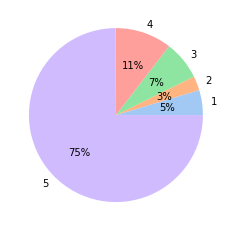

In [107]:
df = [len(data.loc[data["rating"] == 0])/len(data), len(data.loc[data["rating"] == 1])/len(data), len(data.loc[data["rating"] == 2])/len(data), len(data.loc[data["rating"] == 3])/len(data), len(data.loc[data["rating"] == 4])/len(data)]
labels = ['1', '2', '3', '4', '5']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
plt.pie(df, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [3]:
# Видимо, у нас перевес в данных, много 5
# Сделаем бинарную классификацию, 4 и 5 - хороший отзыв - 1, 1-3 - плохой отзыв - 0

# считаем данные 
data_binary = pd.read_excel('all_reviews.xlsx', usecols=['review', 'rating'])
data_binary


,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",5
1,Свежий и вкусный кекс с банановый вкусом и оре...,5
2,Вау вау,5
3,"ужасный вкус, не советую к покупке",1
4,Понравился и мне и коллегам,5
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",5
1956,супер,5
1957,отличное спелое манго!,5
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",5


In [4]:
# изменим классы 1->0, 2-> 1 и так далее
labels_dct = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1}
data_binary = (data_binary
      .query("rating in @labels_dct.keys()")
      .assign(rating=lambda x: x["rating"].replace(labels_dct)))

data_binary

,review,rating
0,"Очень любим этот кекс, постоянно берем в пост.",1
1,Свежий и вкусный кекс с банановый вкусом и оре...,1
2,Вау вау,1
3,"ужасный вкус, не советую к покупке",0
4,Понравился и мне и коллегам,1
...,...,...
1955,"Обожаю это манго, каждый год в сезон балую себя)",1
1956,супер,1
1957,отличное спелое манго!,1
1958,"Взяла 6 кг, хочу чтоб полежали дозрели поесть ...",1


In [5]:
# разделим данные на тест и трэин
X_b = data_binary.review
y_b = data_binary.rating

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=123)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [8]:
# токенизируем и закодируем тексты
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

In [11]:
# Создадим датасеты
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.to_numpy()
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.to_numpy()
)).batch(16)

In [12]:
# загрузим предобученную модель
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# заморозим слои модели
bert_model.trainable = False

In [14]:
num_classes = 2

# Build the classification model
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)[0]
outputs = tf.keras.layers.GlobalMaxPooling1D()(outputs)

dense = tf.keras.layers.Dense(128, activation='relu')(outputs)
dropout = tf.keras.layers.Dropout(0.1)(dense)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)

In [15]:
model_bin = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output])

In [16]:
model_bin.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model_bin.fit(train_dataset, epochs=2)

Epoch 1/2


/home/lizik/.local/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


98/98 [==============================] - 646s 6s/step - loss: 0.4337 - accuracy: 0.8501
Epoch 2/2
98/98 [==============================] - 654s 7s/step - loss: 0.3403 - accuracy: 0.8622


In [18]:
model_bin.save('./model/my_model_bin.h5')

/home/lizik/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
new_model_bin = keras.models.load_model('./model/my_model_bin.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [26]:
# Make predictions
test_texts = ["Вкус ужас!!! Не покупайте", "УЖАССС"]
our_text_encodings = tokenizer(test_texts, truncation=True, padding=True)
our_test_dataset = tf.data.Dataset.from_tensor_slices(dict(our_text_encodings)).batch(32)

In [27]:

predictions = new_model_bin.predict(our_test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
print(predictions)

/home/lizik/.local/lib/python3.8/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 5s 5s/step
[[0.01973562 0.9802643 ]
 [0.0150721  0.9849279 ]]


In [29]:
for text, label in zip(test_texts, predicted_labels):
    print(f"Text: {text}")
    print(f"Predicted Label: {label}")

Text: Вкус ужас!!! Не покупайте
Predicted Label: 1
Text: УЖАССС
Predicted Label: 1


In [ ]:
# train_encodings = tokenizer(X_train, truncation=True, padding=True)
# train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(32)


In [11]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [66]:
# out_features = model.bert.encoder.layer[1].output.dense.out_features
# out_features

In [67]:
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# model.fit(train_dataset, epochs=1)


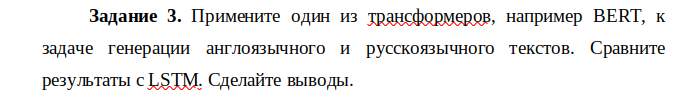

In [30]:
import tensorflow as tf
from transformers import TFAutoModelWithLMHead, AutoTokenizer

# загрузим предобученную модель и токенайзер
model = TFAutoModelWithLMHead.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2')


/home/lizik/.local/lib/python3.8/site-packages/transformers/models/auto/modeling_tf_auto.py:713: FutureWarning: The class `TFAutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `TFAutoModelForCausalLM` for causal language models, `TFAutoModelForMaskedLM` for masked language models and `TFAutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [41]:
# закодируем текст
input_text = "Представляешь, вчера я читала статью в интернете о"
input_ids = tokenizer.encode(input_text, return_tensors='tf')


In [42]:
# Сгенерируем текст
output = model.generate(input_ids, max_length=100, num_return_sequences=1)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [43]:
print("Сгенерированный текст:", generated_text)

Сгенерированный текст: Представляешь, вчера я читала статью в интернете обредения в простический в простический в


In [47]:
input_text = "Когда закончатся эти лабы..."
input_ids = tokenizer.encode(input_text, return_tensors='tf')

In [50]:
# Сгенерируем текст
output = model.generate(input_ids, max_length=100, num_return_sequences=1)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [51]:
print("Сгенерированный текст:", generated_text)

Сгенерированный текст: Когда закончатся эти лабы... Набы простива простива простива простива простива простива простива �


In [44]:
# закодируем текст
input_text = "Can you imagine, yesterday I read an article on the Internet"
input_ids = tokenizer.encode(input_text, return_tensors='tf')

In [45]:
# Сгенерируем текст
output = model.generate(input_ids, max_length=100, num_return_sequences=1)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [46]:
print("Сгенерированный текст:", generated_text)

Сгенерированный текст: Can you imagine, yesterday I read an article on the Internet about a man who was arrested for allegedly raping a woman. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked. I was shocked.


Выводы: трансформеры гораздно лучше улавливают смысл предложения засчет масок внимания => все вводимые данные связаны между собой, LSTM же связывает между собой лишь некоторые определенные данные, за счет чего связь в предложениях хуже, чем при использовании моделей-трансформеров

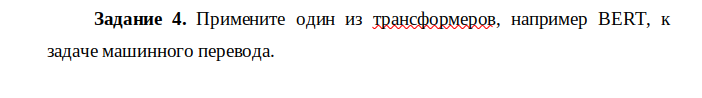

In [116]:

# # Set up the model and tokenizer for translation task
# model_name = "Helsinki-NLP/opus-mt-en-de"
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)


In [71]:
# # Define the translation function
# def translate(text):
#     inputs = tokenizer.encode(text, return_tensors="tf")
#     print(inputs)
#     outputs = model.generate(inputs["input_ids"], max_length=64, num_beams=4, early_stopping=True)
#     translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return translation

# # Translate example text
# example_text = "Hello, how are you?"
# translation = translate(example_text)
# print(f"Input: {example_text}")
# print(f"Translation: {translation}")

In [98]:


from pathlib import Path

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "Helsinki-NLP/opus-mt-en-ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer.save_pretrained(Path.cwd() / 'model' / 'en-ru-local')
model.save_pretrained(Path.cwd() / 'model' / 'en-ru-local')



In [99]:
import sys
import time
from pathlib import Path

from colorama import Fore, init
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM



In [100]:
init()

tokenizer = AutoTokenizer.from_pretrained(Path.cwd() / 'model' / 'en-ru-local')
model = AutoModelForSeq2SeqLM.from_pretrained(Path.cwd() / 'model' / 'en-ru-local')

In [101]:


def translate_phrase(phrase: str) -> str:
    inputs = tokenizer(phrase, return_tensors="pt")
    output = model.generate(**inputs, max_new_tokens=100)
    out_text = tokenizer.batch_decode(output, skip_special_tokens=True)
    print(f'\r{Fore.YELLOW}   {out_text[0]}', end="")
    return out_text[0]



In [102]:
def translate_text(text):
    translate_text = []
    for txt in text:
        translate_text.append(f'{translate_phrase(txt)}\n')
    return translate_text

In [103]:
translate_text("Я не знаю, что делать")

   z)................................................мм хмммм хмммм хмммм хммммм хммммм хммммммммммммм

['хв. й. х х х х х х х х х х х х х х х х х х х х\n',
 'Я не знаю, что делать.\n',
 'О\n',
 'И\n',
 'Я не знаю, что делать.\n',
 'd) хр. хр. хр. х; хр. хм хммм хмм хмм хммм хммм хммм хмммм хмммм хмммм хммммм хммммм хммммммммммммм\n',
 'О\n',
 '..................................................\n',
 'УР\n',
 ',\n',
 'Я не знаю, что делать.\n',
 '(в тыс. долл. США)\n',
 'Т\n',
 'О\n',
 'Я не знаю, что делать.\n',
 'd)................................................\n',
 'И\n',
 'МВ\n',
 '..................................................\n',
 'Т\n',
 'z)................................................\n']

In [113]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def translate(text, lang='ru'):
    if lang == 'ru':
        mname = "Helsinki-NLP/opus-mt-en-ru"
        tokenizer = AutoTokenizer.from_pretrained(mname)
        model = AutoModelForSeq2SeqLM.from_pretrained(mname)
    else:
        mname = "Helsinki-NLP/opus-mt-ru-en"
        tokenizer = AutoTokenizer.from_pretrained(mname)
        model = AutoModelForSeq2SeqLM.from_pretrained(mname)
    inputs = tokenizer(text, return_tensors="pt")
    output = model.generate(**inputs, max_new_tokens=100)
    out_text = tokenizer.batch_decode(output, skip_special_tokens=True)
    return out_text[0]

In [114]:
text = 'Hello! What are you doing today?'
print(translate(text, 'ru'))

Эй, что ты делаешь сегодня?


In [115]:
text = 'Эй, что ты делаешь сегодня?'
print(translate(text, 'en'))

Hey, what are you doing today?


Заполним пропуски

In [65]:
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration

model_name = 't5-base'

t5_tokenizer = T5Tokenizer.from_pretrained(model_name)
t5_config = T5Config.from_pretrained(model_name)
t5_mlm = T5ForConditionalGeneration.from_pretrained(model_name, config=t5_config)

/home/lizik/.local/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [143]:
def _filter(output, end_token='.'):
    _0_index = text.index('_')
    _result_prefix = text[:_0_index]
    _result_suffix = text[_0_index+12:]
    _txt = t5_tokenizer.decode(output[2:], skip_special_tokens=False, clean_up_tokenization_spaces=False)
    if end_token in _txt:
        _end_token_index = _txt.index(end_token)
        return _result_prefix + _txt[:_end_token_index] + _result_suffix
    else:
        return _result_prefix + _txt + _result_suffix


In [144]:
def fill(text):
    
    encoded = t5_tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    input_ids = encoded['input_ids']
    outputs = t5_mlm.generate(input_ids=input_ids, 
                            num_beams=500, num_return_sequences=5,
                            max_length=10)

    results = list(map(_filter, outputs))
    return results

In [145]:
# Input text
text = 'I love _.'

In [146]:
fill(text)

['I love _', 'I love you', 'I love ', 'I love you', 'I love _']

In [147]:
text = 'Do you like _?'
fill(text)

['Do you like Do you like _?</s><pad>',
 'Do you like _? <extra_id_1> _? Do',
 'Do you like _? <extra_id_1> _?</s>',
 'Do you like _? Do you like _',
 'Do you like you like _?</s><pad><pad>']